<h1>Predicting Solubility of Organic Molecules from Molecular Structure</h1>

In this project a model is built to predict the degree of <em>Water Solubility - <b>(logarithm of solubility in mols per litre)</b></em> by using the molecular structure as features for the Deep Learning Model. 
<br>
To train and validate the model, we make use of the <a href="https://moleculenet.org/datasets-1">ESOL Dataset</a> - which comprises of <em>1128</em> common organic molecules. In the dataset each molecule's structure is represented by its respective <b>SMILES</b> string. As water solubility is a <b><em>physical property</em></b> - not requiring assessment of any of its molecular chemical properties, hence information of the relative molecular conformers is not necessary i.e. 3D coordinates of molecular components.

In [1]:
import sys
from rdkit import Chem
import torch
import torch.nn.functional as F

from torch_geometric.nn import GCNConv, TopKPooling
from torch_geometric.nn import global_mean_pool as gap
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.datasets import MoleculeNet
from torch_geometric.data import DataLoader

import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings

sys.path.append("./gnns/")
from esolModel import esolModel

C:\Users\palin\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<h3>Load & Inspect the ESOL Dataset</h3>

In [2]:
# Load the 'ESOL' component of the dataset
data = MoleculeNet(root='.', name="ESOL")
data

ESOL(1128)

In [3]:
# inspect the dataset
print("Inspecting the dataset...\nDataset Type: {}\nNumber of features per molecule: {} | Number of Classes: {}\nNumber of Datapoints: {}".format(type(data), data.num_features, data.num_classes, data.len))

Inspecting the dataset...
Dataset Type: <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Number of features per molecule: 9 | Number of Classes: 734
Number of Datapoints: <bound method InMemoryDataset.len of ESOL(1128)>


In [4]:
# inspecting a sample of the dataset
print("Inspecting a Molecule Graph data sample..\nFirst Molecule Graph Data in dataset: {}\nNumber of Nodes in Molecule Graph: {} | Number of Edges in Molecule Graph: {}".format(data[0], data[0].num_nodes, data[0].num_edges))
print("\nInspect the features in the data sample:")
display(data[0].x)
print("\nThe target variable for the Graph Data sample:")
display(data[0].y)
# print(data[0].edge_index.t()) # Get the Edge Insformation i.e. tuple of nodes connected by an edge.
print("The graph data has 32 nodes & each node is comprised of Node-features which consists of a tensor of 9 features for each node.")

Inspecting a Molecule Graph data sample..
First Molecule Graph Data in dataset: Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], y=[1, 1], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ')
Number of Nodes in Molecule Graph: 32 | Number of Edges in Molecule Graph: 68

Inspect the features in the data sample:


tensor([[8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 0],
        [6, 0, 2, 5, 0, 0, 2, 0, 0],
        [7, 0, 1, 5, 0, 0, 2, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
 


The target variable for the Graph Data sample:


tensor([[-0.7700]])

The graph data has 32 nodes & each node is comprised of Node-features which consists of a tensor of 9 features for each node.


<hr style="border: 3px double gray"></hr>
Upon inspecting the dataset - The target variable comprises of a single real (<em>float</em>) value - which indicates this as a <b><em>graph-level prediction problem</em></b>.
Each data-point in the dataset represents the molecular structure as a combination of <b>nodes</b> with associated features, i.e. <b>'node-features'</b>. Each node has corresponding <b>9 features</b> associated with it which encapsulates edge features associated with the respective node as well.
<h4>For each <em>SMILE string</em> - there is only <u>one</u> target variable for the entire molecule (graph data)</h4>

Inspect a sample of molecule SMILES and the corresponding molecular structure.

Molecule SMILES string:  OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O 


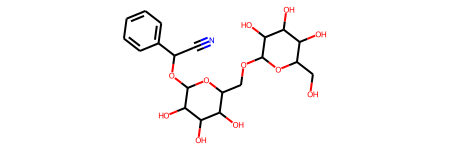

---------------------------------------------
Molecule SMILES string:  Cc1occc1C(=O)Nc2ccccc2


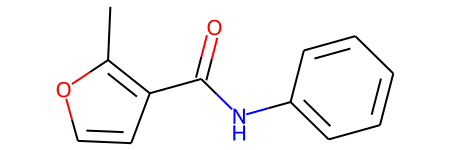

---------------------------------------------
Molecule SMILES string:  CC(C)=CCCC(C)=CC(=O)


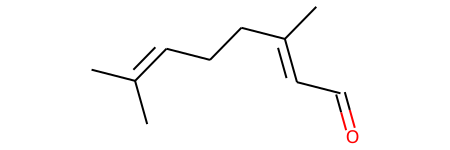

---------------------------------------------
Molecule SMILES string:  c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43


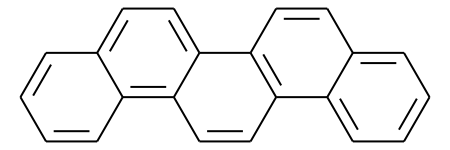

---------------------------------------------
Molecule SMILES string:  c1ccsc1


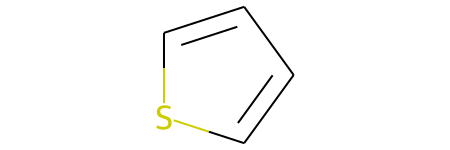

---------------------------------------------
Molecule SMILES string:  c2ccc1scnc1c2 


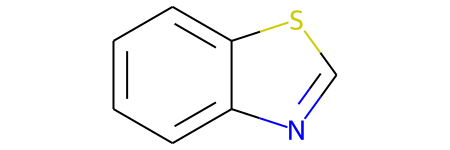

---------------------------------------------
Molecule SMILES string:  Clc1cc(Cl)c(c(Cl)c1)c2c(Cl)cccc2Cl


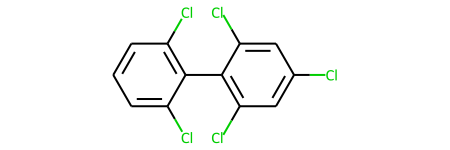

---------------------------------------------
Molecule SMILES string:  CC12CCC3C(CCc4cc(O)ccc34)C2CCC1O


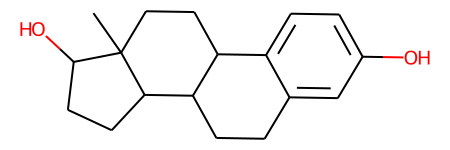

---------------------------------------------
Molecule SMILES string:  ClC4=C(Cl)C5(Cl)C3C1CC(C2OC12)C3C4(Cl)C5(Cl)Cl


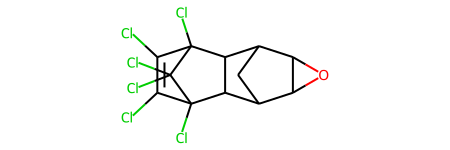

---------------------------------------------
Molecule SMILES string:  COc5cc4OCC3Oc2c1CC(Oc1ccc2C(=O)C3c4cc5OC)C(C)=C 


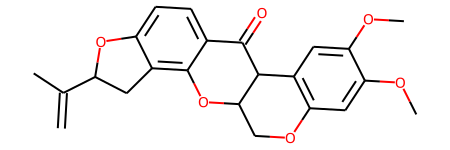

---------------------------------------------


In [5]:
# Visualizing Molecules
# Use RDKit to visualize molecular features of first 10 graph data samples

for i in range(10):
    molecule = Chem.MolFromSmiles(data[i]['smiles'])
    print("Molecule SMILES string: ", data[i]['smiles'])
    display(molecule)
    print('---------------------------------------------')

<hr style="border: 4px double orange;"></hr>
<h3>Modelling with Deep Graph Neural Nets</h3>

Create a baseline Model to benchmark the performance, on top of which a refined GNN model can be built to obtain improved predictions on water solubility.

In [6]:
# Implementing Baseline Graphical Neural network

class baseGCN(torch.nn.Module):
    def __init__(self, n_features, embedding_size):
        super(baseGCN,self).__init__()
        torch.manual_seed(95)
        
        # Initialise the Base Model Architecture
        self.in_conv = GCNConv(n_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)
        
        # output layer of the Graph Neural Net
        self.out = torch.nn.Linear(embedding_size*2, 1)
        
    def forward(self, x, edge_index, batch_index):
        
        hidden = self.in_conv(x, edge_index)
        hidden = F.tanh(hidden)
        
        # Graph Message Passing
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)
        
        # Apply Pooling at Graph-level i.e. Global Pooling
        # Pooling mechanism to represent the Graph of any number of nodes in to an array of fixed size
        # Concatenate the Global Pooling of Mean (G.A.P) & Max (G.M.P) of these features into a single representation
        hidden = torch.cat([gmp(hidden, batch_index), gap(hidden, batch_index)], dim=1)
        
        # Apply a final (linear) regressor
        out = self.out(hidden)
        
        return out, hidden
    
emb_size = 64
baseModel = baseGCN(data.num_features, emb_size)

display(baseModel)

baseGCN(
  (in_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)

In [7]:
# Summarize the instantiated Base Model
print("Number of Model Parameters: ", sum(p.numel() for p in baseModel.parameters()))

Number of Model Parameters:  13249


<h3>Compile the <em>baseline</em> model & define the Loss & Optimisation functions</h3>

In [8]:
# Use the GPU for Model training if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
baseModel = baseModel.to(device)

# Define the Objective Function for Base Model compilation
# MSE -> Objective / Loss Funciton
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(baseModel.parameters(), lr = 0.0005)

# Use Data Loader to collate Data into batches
data_size = len(data)
batch_size = 64

# Pass 75% of the data as Train to the Data Loader
train_data_loader = DataLoader(data[:int(data_size * 0.75)], batch_size=batch_size, shuffle=True)

# Pass 25% of the data as Test to the Data Loader
test_data_loader = DataLoader(data[int(data_size * 0.75):], batch_size=batch_size, shuffle=True)

def model_train(data):
    
    for batch_data in train_data_loader:
        
        batch_data=batch_data.to(device)
        optimizer.zero_grad()
        prediction, embedding = baseModel(batch_data.x.float(), batch_data.edge_index, batch_data.batch)
        loss_val = loss_function(prediction, batch_data.y)
        loss_val.backward()
        optimizer.step()
    return loss_val, embedding

C:\Users\palin\Anaconda3\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


<h4>Train the Baseline Model</h4>

In [9]:
epochs = 2500
hist_loss = []

for epoch in range(epochs):
    loss, h = model_train(data)
    hist_loss.append(loss)
    if epoch%100 == 0:
        print("Completed Epochs: {} -> Loss: {}".format(epoch, loss))

C:\Users\palin\Anaconda3\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Completed Epochs: 0 -> Loss: 3.5793051719665527
Completed Epochs: 100 -> Loss: 2.4431710243225098
Completed Epochs: 200 -> Loss: 1.113114833831787
Completed Epochs: 300 -> Loss: 0.6751129627227783
Completed Epochs: 400 -> Loss: 0.2598721981048584
Completed Epochs: 500 -> Loss: 0.28296300768852234
Completed Epochs: 600 -> Loss: 0.22908064723014832
Completed Epochs: 700 -> Loss: 0.19578172266483307
Completed Epochs: 800 -> Loss: 0.4741448163986206
Completed Epochs: 900 -> Loss: 0.37046024203300476
Completed Epochs: 1000 -> Loss: 0.21676291525363922
Completed Epochs: 1100 -> Loss: 0.1741177886724472
Completed Epochs: 1200 -> Loss: 0.5745912790298462
Completed Epochs: 1300 -> Loss: 0.1163138821721077
Completed Epochs: 1400 -> Loss: 0.12129074335098267
Completed Epochs: 1500 -> Loss: 0.22089046239852905
Completed Epochs: 1600 -> Loss: 0.10361021012067795
Completed Epochs: 1700 -> Loss: 0.1024099662899971
Completed Epochs: 1800 -> Loss: 0.07872648537158966
Completed Epochs: 1900 -> Loss: 0.1

In [11]:
# Save the Trained Model
torch.save(baseModel, "./models/ESOL_baseModel.pth")

<h3>Inspect the Loss Curve over successive Train Epochs</h3>

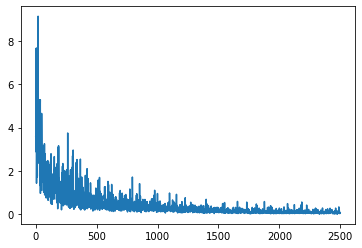

In [10]:
%matplotlib inline

# Baseline Model was trained over 2500 epochs
hist_losses = [float(loss.cpu().detach().numpy()) for loss in hist_loss[:]]
loss_index = [i for i in range(len(hist_losses))]

plt = sns.lineplot(loss_index, hist_losses)
plt

<h3>Evaluate the Model over a Validation Dataset</h3>

In [21]:
# Obtaining The test predictions - Load the Stored baseline model
model_save_path = "./models/ESOL_baseModel.pth"
base_model= torch.load( model_save_path )
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
base_model = base_model.to(device)

<h4>Obtain relevant predictions on the validation dataset</h4>

In [22]:
test_batch_data = next(iter(test_data_loader))

with torch.no_grad():
    test_batch_data = test_batch_data.to(device)
    prediction, embedding = base_model(test_batch_data.x.float(), test_batch_data.edge_index, test_batch_data.batch)
    df = pd.DataFrame()
    df['y_truth'] = test_batch_data.y.tolist()
    df['y_predict'] = prediction.tolist()

df['y_truth'] = df['y_truth'].apply(lambda row: row[0])
df['y_predict'] = df['y_predict'].apply(lambda row: row[0])
display(df)

C:\Users\palin\Anaconda3\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


,y_truth,y_predict
0,-3.59,-5.357649
1,-0.17,-1.843094
2,-0.85,-0.854907
3,-3.10,-3.829373
4,-2.21,-2.132792
...,...,...
59,-3.15,-2.974726
60,-5.24,-5.256596
61,-1.01,-1.509138
62,0.51,0.150229


<hr style="border:3px double blue;"></hr>
<h3>Inspect Model Performance on Test Data</h3>

Since this is a <b>Regression Problem</b> with a single target variable, a model which gives predicted value for solubility as close to the <em>target variable</em> as possible is the one which is most desireable. So if we use <b><em>('Ground-Truth', 'Prediction')</em></b> as absicca - ordinate pair to define a data-point & plot it on a cartesian plane i.e. <em>X = "Ground-Truth" | Y = "Prediction"</em> - an ideal model's prediction would return a line <u>close to</u> (<em>but not exactly</em>) <b>X ≈ Y</b> i.e. <b><em>"Prediction" ≈ "Ground-Truth"</em></b>.

<b>NOTE: </b>Identity Line, <em><b>X = Y</b></em> is shown in <span style="color: red">red</span>.

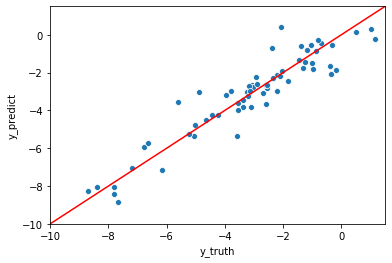

In [28]:
%matplotlib inline

plot=sns.scatterplot(data=df, x="y_truth", y="y_predict")
sns.lineplot([-12, 2], [-12, 2], color="r", dashes=[(2, 2)])
plot.set(xlim=(-10, 1.5))
plot.set(ylim=(-10, 1.5))

plot

<h4>Inspect Baseline-Model Performance on the entire dataset</h4>

In [3]:
def all_data_eval(data, model, device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu") ):
    all_data = DataLoader(data, batch_size=batch_size, shuffle=True)
    # all_data_iter = next(iter(all_data))
    df = {'y_truth': [], 'y_predict': []}
    with torch.no_grad():
        for all_data_batch in all_data:
            all_data_batch = all_data_batch.to(device)
            prediction, embedding = model(all_data_batch.x.float(), all_data_batch.edge_index, all_data_batch.batch)

            df['y_truth']+= all_data_batch.y.tolist()
            df['y_predict']+= prediction.tolist()
    
    df = pd.DataFrame(df)
    df['y_truth'] = df['y_truth'].apply(lambda row: row[0])
    df['y_predict'] = df['y_predict'].apply(lambda row: row[0])
    
    return df

In [30]:
base_pred_df = all_data_eval(data, base_model)
base_pred_df

C:\Users\palin\Anaconda3\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
C:\Users\palin\Anaconda3\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


,y_truth,y_predict
0,1.120,1.167301
1,-3.730,-3.542468
2,0.740,0.827182
3,-1.230,-1.288209
4,-3.140,-3.078417
...,...,...
1123,-2.658,-2.424474
1124,0.540,0.564313
1125,-2.560,-2.635663
1126,-6.620,-6.722585


MSE of the Base Model predictions over the entire dataset: 0.21219844920930298 | Mean Absolute Error: 0.24474308388439794


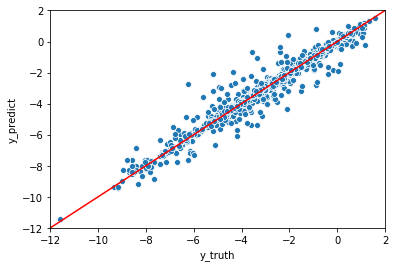

In [31]:
%matplotlib inline

print("MSE of the Base Model predictions over the entire dataset: {} | Mean Absolute Error: {}".format(
                                                                  mean_squared_error(base_pred_df.y_truth, base_pred_df.y_predict),
                                                                  mean_absolute_error(base_pred_df.y_truth, base_pred_df.y_predict)
                                                                                                  )
     )

plot=sns.scatterplot(data=base_pred_df, x="y_truth", y="y_predict")
sns.lineplot([-12, 2], [-12, 2], color="r")
plot.set(xlim=(-12, 2))
plot.set(ylim=(-12, 2))

plot

<h4>Baseline Model Performance Observation -</h4>

The Baseline Model perform surprisingly well with an <b>MSE</b> of <em>0.212</em>. While inspecting the plot with each datapoints' absicca & ordinate values given as<em>x = "Ground-Truth" | y = "Prediction")</em>, it can be observed that the plot could be more condensed to a straigth line <em>(X=Y)</em> with a couple of <em>straggler</em> data-points which can be better predicted with a more refined model.

<h3>Building a refined Model & Evaluting its Performance</h3>

Before instantiating the refined model, we need to figure out a <b>Learning-Rate Scheduler</b> which decays the learning-rate over successive epochs.

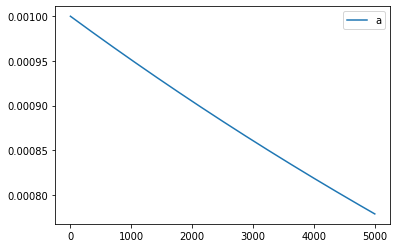

In [6]:
%matplotlib inline

a = []
# intial value of the Learning-rate
initLR = 0.001

for epo in range(5000):
    a.append( initLR*(np.e**(-epo/20000)) )

# plot the learning rate value over successive epochs as it decays over time
pd.DataFrame({'a' : a}).plot()

In [5]:
emb_size = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = esolModel(data.num_features, emb_size)
model = model.to(device)

display(model)
# Summarize the instantiated Model
print("Number of Model Parameters: ", sum(m.numel() for m in model.parameters()))

esolModel(
  (in_conv): GCNConv(9, 64)
  (conv1): GATv2Conv(64, 64, heads=4)
  (gnorm): GraphNorm(64)
  (conv2): GCNConv(64, 64)
  (gnorm2): GraphNorm(64)
  (conv3): GCNConv(64, 64)
  (conv4): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)

Number of Model Parameters:  47233


The <em>refined model</em> has more than <b>twice</b> the number of learnable parameters as the <b><em>Base Model</em></b>.

<hr style="border: 3px double blue;"></hr>

<h3>Compile & Train the Model</h3>

In [7]:
# Use the GPU for Model training if available
# MSE -> Objective / Loss Funciton
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)
num_epochs = 5000
decay_const = 4.5*num_epochs

lr_schedule = lambda epoch: (np.e)**(-epoch/decay_const)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_schedule)

# Use Data Loader to collate Data into batches
data_size = len(data)
batch_size = 64

# Pass 75% of the data as Train to the Data Loader
train_data_loader = DataLoader(data[:int(data_size * 0.75)], batch_size=batch_size, shuffle=True)

# Pass 25% of the data as Test to the Data Loader
test_data_loader = DataLoader(data[int(data_size * 0.75):], batch_size=batch_size, shuffle=True)

def model_train(data):
    
    for batch_data in train_data_loader:
        
        batch_data=batch_data.to(device)
        optimizer.zero_grad()
        prediction, embedding = model(batch_data.x.float(), batch_data.edge_index, batch_data.batch)
        loss_val = loss_function(prediction, batch_data.y)
        loss_val.backward()
        
        optimizer.step()
        
    return loss_val, embedding

C:\Users\palin\Anaconda3\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [8]:
hist_loss = []

for epoch in range(num_epochs):
    loss, _ = model_train(data)
    hist_loss.append(loss)
    if epoch%100 == 0:
        print("Completed Epochs: {} -> Loss: {}".format(epoch, loss))
    scheduler.step()

C:\Users\palin\Anaconda3\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Completed Epochs: 0 -> Loss: 4.633730411529541
Completed Epochs: 100 -> Loss: 1.6038485765457153
Completed Epochs: 200 -> Loss: 0.5125581622123718
Completed Epochs: 300 -> Loss: 0.2636226713657379
Completed Epochs: 400 -> Loss: 0.14102110266685486
Completed Epochs: 500 -> Loss: 0.13448098301887512
Completed Epochs: 600 -> Loss: 0.047903046011924744
Completed Epochs: 700 -> Loss: 0.040809184312820435
Completed Epochs: 800 -> Loss: 0.03769299015402794
Completed Epochs: 900 -> Loss: 0.21341626346111298
Completed Epochs: 1000 -> Loss: 0.037583693861961365
Completed Epochs: 1100 -> Loss: 0.07403724640607834
Completed Epochs: 1200 -> Loss: 0.1523086279630661
Completed Epochs: 1300 -> Loss: 0.013843780383467674
Completed Epochs: 1400 -> Loss: 0.06211886554956436
Completed Epochs: 1500 -> Loss: 0.02931373193860054
Completed Epochs: 1600 -> Loss: 0.05154039338231087
Completed Epochs: 1700 -> Loss: 0.026229839771986008
Completed Epochs: 1800 -> Loss: 0.007462234701961279
Completed Epochs: 1900 -

<h4>Inspect the Loss over successive train-epochs</h4>

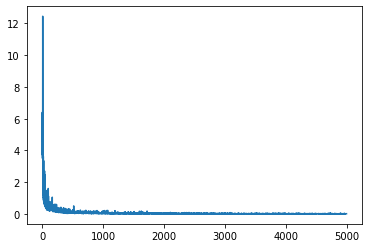

In [11]:
%matplotlib inline

# Inspect the model Loss
hist_losses = [float(loss.cpu().detach().numpy()) for loss in hist_loss]
loss_index = [i for i in range(len(hist_losses))]

plt = sns.lineplot(loss_index, hist_losses)
plt

In [17]:
# save the Model
#torch.save(model, "./models/ESOL_betaModel.pth")
torch.save(model, "./models/ESOL_betaModel_v2.0.pth")

<h3>Obtain & Inspect predictions over the Test Dataset</h3>

In [12]:
model = torch.load("./models/ESOL_betaModel_v2.0.pth")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

test_batch_data = next(iter(test_data_loader))

with torch.no_grad():
    test_batch_data = test_batch_data.to(device)
    prediction, embedding = model(test_batch_data.x.float(), test_batch_data.edge_index, test_batch_data.batch)
    df = pd.DataFrame()
    df['y_truth'] = test_batch_data.y.tolist()
    df['y_predict'] = prediction.tolist()

df['y_truth'] = df['y_truth'].apply(lambda row: row[0])
df['y_predict'] = df['y_predict'].apply(lambda row: row[0])
display(df)

C:\Users\palin\Anaconda3\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


,y_truth,y_predict
0,-6.680,-7.194107
1,-3.246,-3.050872
2,-4.445,-5.349409
3,-7.820,-8.340064
4,-5.230,-3.740345
...,...,...
59,-1.790,-1.623713
60,-0.670,-0.948405
61,-4.799,-4.055529
62,-3.500,-2.897092


In [13]:
print("Range of the Predicted variable -> Min: {} | Max: {}".format(df.y_predict.min(), df.y_predict.max()))
print("Range of the Target variable -> Min: {} | Max: {}".format(df.y_truth.min(), df.y_truth.max()))

Range of the Predicted variable -> Min: -8.872827529907227 | Max: 1.0390598773956299
Range of the Target variable -> Min: -7.820000171661377 | Max: 1.1440000534057617


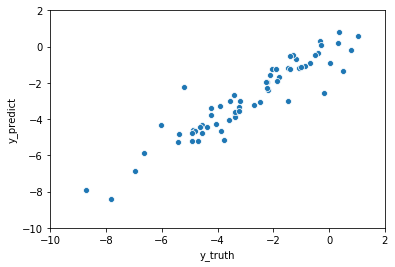

In [74]:
%matplotlib inline

plot=sns.scatterplot(data=df, x="y_truth", y="y_predict")

plot.set(xlim=(-10, 2))
plot.set(ylim=(-10, 2))

plot

<h3>Inspect Model Predictions for the Entire Dataset</h3>

In [15]:
pred_df = all_data_eval(data, model)

print("Range of the Predicted variable -> Min: {} | Max: {}".format(pred_df.y_predict.min(), pred_df.y_predict.max()))
print("Range of the Target variable -> Min: {} | Max: {}".format(pred_df.y_truth.min(), pred_df.y_truth.max()))

display(pred_df)

C:\Users\palin\Anaconda3\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
C:\Users\palin\Anaconda3\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Range of the Predicted variable -> Min: -11.675378799438477 | Max: 1.5713399648666382
Range of the Target variable -> Min: -11.600000381469727 | Max: 1.5800000429153442


,y_truth,y_predict
0,-1.000,-0.972344
1,-1.850,-1.810759
2,-0.490,-0.591831
3,-4.862,-4.854700
4,-3.270,-3.194841
...,...,...
1123,-3.610,-3.606540
1124,-0.807,-0.849019
1125,1.100,1.319252
1126,-1.090,-1.025608


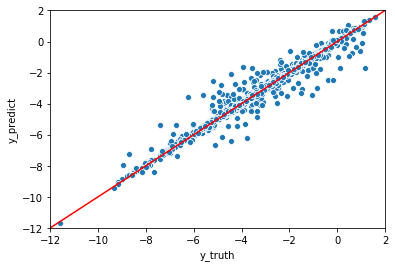

In [16]:
%matplotlib inline

# inspect the data plots with absicca as ground-truth values & ordinate as predicted values
plot=sns.scatterplot(data=pred_df, x="y_truth", y="y_predict")
sns.lineplot([-12, 2], [-12, 2], color="r")
plot.set(xlim=(-12, 2))
plot.set(ylim=(-12, 2))

plot

In [14]:
print("MSE of the model predictions over the entire dataset: {} | Mean Absolute Error: {}".format(
                                                                  mean_squared_error(pred_df.y_truth, pred_df.y_predict),
                                                                  mean_absolute_error(pred_df.y_truth, pred_df.y_predict)
                                                                                                  )
     )

MSE of the model predictions over the entire dataset: 0.1838070614214383 | Mean Absolute Error: 0.20784129944121374


<hr style='border: 4px double blue'></hr>
<h3>Observation- Refined Model Performance</h3>

The Model performs better than the baseline with <b>MSE</b> of <em>0.183</em>. The plot with each datapoints' absicca & ordinate values given as<em>x = "Ground-Truth" | y = "Prediction")</em>, is also more tightly packed and closer to the <b>Identity Line</b> <em style="color: red;">(X=Y)</em> which indicates better performance than the base-line model.